# Thin plate inversion

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_single_transmitter.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [3]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import arviz
import cofi

from forward_lib import (
    problem_setup, 
    system_spec,
    survey_setup, 
    true_model, 
    ForwardWrapper, 
    plot_transient, 
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

## Background

When modelling the electromagnetic response of subvertical bodies such as a VMS deposit they can be approximated using a thin plate in the halfspace of a layered earth, that is the forward solver computes the 3D response of a thin plate. Here we develop a thin plate inversion method using CoFI to solver the inverse problem and P223 (Raiche et. al., 2007) to solve the forward problem. The thin plate is parameterised using the parametrisation introduced in (Hauser et. al. 2016)

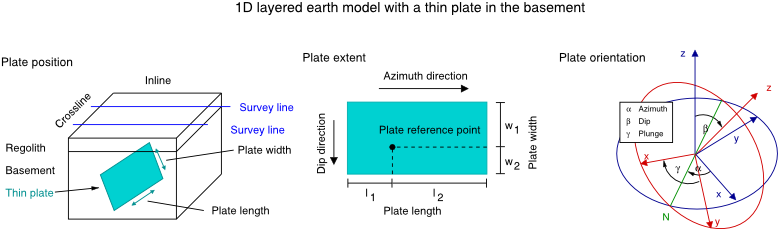

### Forward solver

The forward solver is LeroiAir (Raiche et. al, 2007) and the code has been reorganised so that the response measrued by an AEM system is give by a function that can be called from Python. Plates are discretised into cells, with the accuracy of the forward solver a function of the chosen cell-size. The forward solver is kept in a seperate Python package that is avaiable [here](https://github.com/JuergHauser/PyP223.git)


#### Jacobian via finite differencing

Parameter estimation methods frequently rely on the provison of a Jacoabian for efficient optimisaiton. If an analytical Jacobian is not available it can be computed via finite differencing.
$
f'(x_0) = {f(x_0 +h)-f(x_0)\over h}
$

Care must be taken when choosing the step size $h$ as a too small step size my result in a Jacobian that is affected by a limited accuracy of the forward solver and a too large step size $h$ might result in a Jacobian that is not representative of the derivatives at location $x_0$. In the following we use a relative step size $q$ that is $h=x0*(1.0+q)$. Further to this the gradient of the objective functions itself is affected by the noise on the data, thus for noisy data choosing a larger step size when computing the Jacobian can be advisable.


#### VTEM Max

Airborne electromagnetic systems can be categroised into either helicopter or fixed wing systems. The examples in this directory use a VTEM Max system which is a helicpter based system developed and operated by Geotech.

https://geotech.ca/services/electromagnetic/vtem-versatile-time-domain-electromagnetic-system/

### References

Hauser, J., Gunning, J., & Annetts, D. (2016). Probabilistic inversion of airborne electromagnetic data for basement conductors. Geophysics, 81(5), E389-E400.

Raiche, A., Sugeng, F. and Wilson, G. (2007) Practical 3D EM inversion the P223F software suite, ASEG Extended Abstracts, 2007:1, 1-5



## Inverting for the dip of a thin plate given a single fiducial

In the following we look at a thin plate with a concutacn eof $20 \mathrm{S}$ located in a halfpsapace with a resistivity of 
$1000 \mathrm{\Omega m}$ with a $20 \mathrm{m}$ thick Regolith that has a resitvity of $300 \mathrm{\Omega m}$. The problem setup is imorted from `forward_lib.py` but can be adjusted for other applications. The wrapper is created so that we can declare model parameters which are a subset of all the model parameters required by the forwrd sovler. This allows to for example invert only for dip of the thin plate with all the other mode paremters assumed to be known. 

### Problem definition

In [4]:
survey_setup = {
    "tx": numpy.array([205.]),                  # transmitter easting/x-position
    "ty": numpy.array([100.]),                  # transmitter northing/y-position
    "tz": numpy.array([50.]),                   # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90.])),  # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6.])),  # transmitter inclination
    "rx": numpy.array([205.]),                  # receiver easting/x-position
    "ry": numpy.array([100.]),                  # receiver northing/y-position
    "rz": numpy.array([50.]),                   # receiver height/z-position
    "trdx": numpy.array([0.]),                  # transmitter receiver separation inline
    "trdy": numpy.array([0.]),                  # transmitter receiver separation crossline
    "trdz": numpy.array([0.]),                  # transmitter receiver separation vertical
}

In [5]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup, ["pdip"])
true_param_value = numpy.array([60])

['pdip']


#### True model

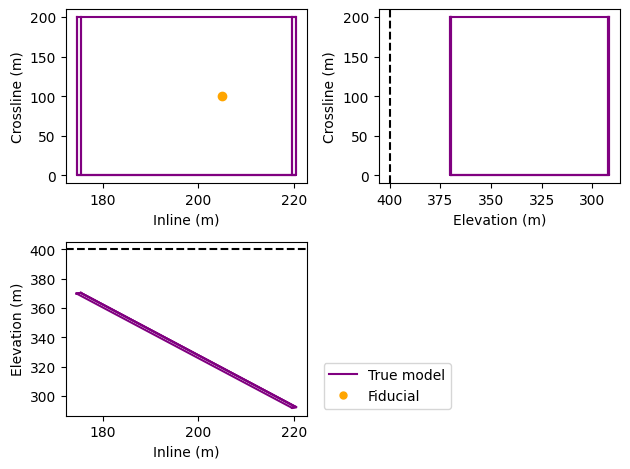

In [6]:
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")



#### Generate synthetic data 

In [7]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

#### Starting model

Set an initial guess for the dip of the thin plate

In [8]:
init_param_value = numpy.array([45])

#### Define helper functions for inversion

In [9]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step=0.1)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return jacobian.T @ Cdinv @ jacobian

def my_log_likelihood(model):
    #print(my_objective(model))
    return -0.5 * my_objective(model)

def my_log_prior(m):    # uniform distribution
    for i in range(len(m)):
        if m[i] < m_min[i] or m[i] > m_max[i]: return -numpy.inf
    return 0.0 # model lies within bounds -> return log(1)

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

#### Sensitivity of the misfit function and usefulness of the gradient

When setting up a new inverse problem prior to any inversion it makes sense to verify that the misfit function is sensitve to the parameter of itnerest and that the gradient of the objective function points in the right direction.

pdip: [40], data misfit: 231.708835656254, gradient: [-8.38525334]
pdip: [45], data misfit: 161.52059630302878, gradient: [-5.17711959]
pdip: [50], data misfit: 115.89689554155724, gradient: [-3.41393833]
pdip: [55], data misfit: 91.0843855955822, gradient: [-1.79238028]
pdip: [60], data misfit: 78.13208270691166, gradient: [-0.40612889]
pdip: [65], data misfit: 79.47542276986738, gradient: [0.60701868]
pdip: [70], data misfit: 86.57794284916837, gradient: [0.77951888]
pdip: [75], data misfit: 99.82377503892143, gradient: [1.04776418]
pdip: [80], data misfit: 114.82121927725917, gradient: [1.88028555]
pdip: [85], data misfit: 135.80364266137616, gradient: [1.99672184]
pdip: [90], data misfit: 158.91312196239573, gradient: [2.12201565]
pdip: [95], data misfit: 190.36506697630017, gradient: [1.90338506]
pdip: [100], data misfit: 211.34574782298415, gradient: [3.0843773]
pdip: [105], data misfit: 248.95857134110955, gradient: [3.54243063]
pdip: [110], data misfit: 283.9454162116735, gradi

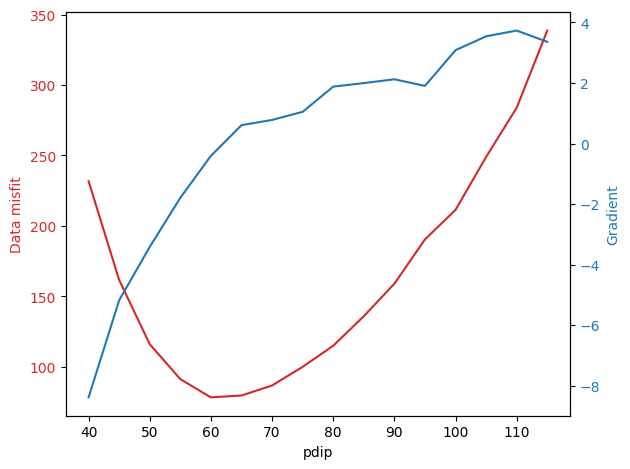

In [10]:
all_models = [numpy.array([pdip]) for pdip in range(40, 120, 5)]
all_misfits = []
all_gradients = []
for model in all_models:
    misfit = my_objective(model)
    gradient = my_gradient(model)
    all_misfits.append(misfit)
    all_gradients.append(gradient)
    print(f"pdip: {model}, data misfit: {misfit}, gradient: {gradient}")


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(all_models, all_misfits,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel("pdip")
ax1.set_ylabel("Data misfit",color=color)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.plot(all_models, all_gradients,color=color)
ax2.set_ylabel('Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Parameter estimation

#### Define CoFI problem

In [11]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

#### Define CoFI options

In [12]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG",callback=PerIterationCallbackFunction())

#### Define and run CoFI inversion

In [13]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 77.89136366904667
Iteration #2
  objective value: 77.67785905000744
[59.18480808]


#### Visualisation

##### Data

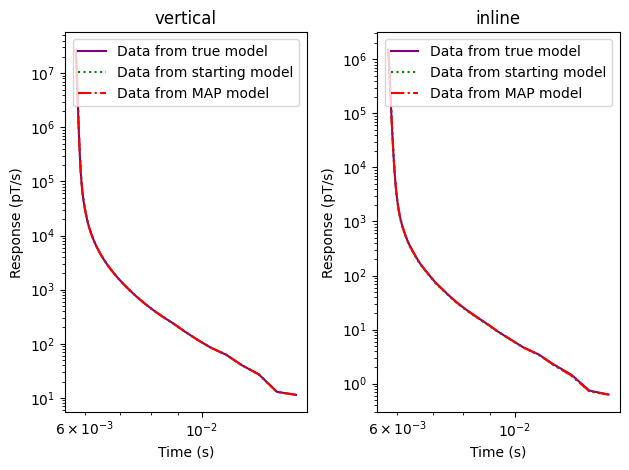

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2)
plot_transient(true_param_value, forward, "Data from true model", ax1, ax2, color="purple")
plot_transient(init_param_value, forward, "Data from starting model", ax1, ax2, color="green", linestyle=":")
plot_transient(my_result.model, forward, "Data from MAP model", ax1, ax2, color="red", linestyle="-.")
ax1.legend(loc="upper center")
ax2.legend(loc="upper center")
ax1.set_title("vertical")
ax2.set_title("inline")
plt.tight_layout()

##### Model

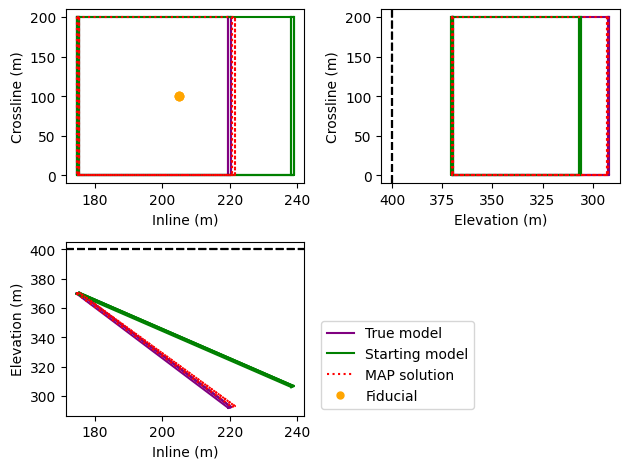

In [15]:
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="MAP solution", linestyle="dotted"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

### Ensemble method

In [16]:
m_min=numpy.array([10])
m_max=numpy.array([80])

#### Augment CoFI problem

In [17]:
my_problem.set_log_prior(my_log_prior)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_model_shape(len(init_param_value))

In [18]:
my_log_likelihood([44.77073457])       

np.float64(-81.38068331700802)

In [19]:
nwalkers = 3
ndim = len(init_param_value)
nsteps = 500
walkers_start = init_param_value + 1 * numpy.random.randn(nwalkers, ndim)

In [20]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("emcee")
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start, progress=True)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
inv_result = inv.run()

######## Check result
print(f"The inversion result from `emcee`:")
inv_result.summary()

100%|██████████████████████████████████████████████████████████████████████████| 500/500 [15:47<00:00,  1.90s/it]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


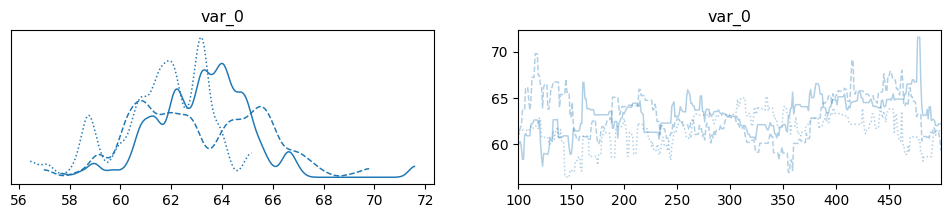

In [21]:
sampler = inv_result.sampler
az_idata = inv_result.to_arviz()
labels = ["plate dip"]
arviz.plot_trace(az_idata.sel(draw=slice(100,None)));

# See also

- Synthetic examples
    - Inverting a single survey line
        - [Inline and vertical component](./single_survey_line.ipynb).
        - [Vertical component only](./single_survey_line_vertical_only.ipynb)
    - Inverting three survey lines
        - [Optimisation](./three_survey_lines.ipynb)
        - Surrogate model
            - [Latin Hypercube Sampling](./three_survey_lines_latin_hypercube_sampling.ipynb)
            - [Surrogate model creation](./three_survey_lines_surrogate_model_creation.ipynb)
            - [Inference using the surrogated model](./three_survey_lines_use_surrogate_model.ipynb) 
- Caber deposit
    - [Preprocessing](./caber_preprocessing.ipynb)
    - [Inversion](./caber_inversion.ipynb)


---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [22]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
